In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
%matplotlib inline

In [37]:
# load abbreviations file
# note that the file is encoded in latin-1, instead of Python's default utf-8 or the common ascii encoding
raw_abbrs = [line.decode('latin-1') for line in open('../data/stateabbr.data', 'rb')]

# get raw samples with the locations as a list
raw_samples = [sample.decode('latin-1').strip().split(',') for sample in open('../data/plants.data', 'rb')]


In [38]:
# parse the abbreviations, not every line is a location and not every abbreviation is 2 letters
# however, every abbreviation is lower case
samples_dict = {}
sample_count = len(raw_samples)
for line in raw_abbrs:
    m = re.search('^([a-z]{2,})\s', line)
    if m:
        abbr = m.group(0).replace(' ', '')
        # pre-populate with zeros
        samples_dict[abbr] = np.zeros(sample_count, dtype=np.int8)
print("Num Locations: {}".format(len(samples_dict.keys())))

Num Locations: 68


In [39]:
# there should be 70 locations, turns out "Prince Edward Island" does not have an abbreviation
# also, samples have an abbreviation the location "pe" and "gl" which is not in stateabbr.txt
# let's assume pe == "Prince Edward Island" and gl == "GreenLand" and add it to the dictionary
samples_dict['pe'] = np.zeros(sample_count, dtype=np.int8)
samples_dict['gl'] = np.zeros(sample_count, dtype=np.int8)

all_locations = set(samples_dict.keys())
# assign 1 for the locations
for i in range(0, sample_count):
    abbrs = set(raw_samples[i][1:])
    for abbr in abbrs:
        samples_dict[abbr][i] = 1 

plants_df = pd.DataFrame(data=samples_dict)
number_of_clusters = [2,3,6,14]
number_of_dimensions = 2

In [60]:
def kmeans_of_sample(df, sample_size, i , clusters):
    temp_df = df.sample(sample_size)
    pca = PCA(n_components=number_of_dimensions)
    pca.fit(temp_df)
    plants_2d = pca.transform(temp_df)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(20, 10)
    y_lower = 10
    X = temp_df.as_matrix()

    
    print("{} :: START :: i={} c={}".format(datetime.datetime.now(), i, clusters))
    tstart = datetime.datetime.now()
    fig.add_subplot(101+i+10*len(number_of_clusters))
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(temp_df)
    cluster_labels = kmeans.labels_
    labels = ['cluster ' + str(label+1) for label in kmeans.labels_]
    ax2 = sns.swarmplot(x=plants_2d[:,0], y=plants_2d[:,1], hue=labels, ax=ax2)
    ax2.set(xticklabels=[])
    ax2.set(yticklabels=[])
    ax2.legend(loc='upper right')
    if i == 3: 
        ax2.legend_.remove()
    print("{} :: DONE KMeans :: {}".format(datetime.datetime.now(), datetime.datetime.now() - tstart ))
    silhouette_avg = silhouette_score(temp_df, kmeans.labels_)
    print("For n_clusters =", clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(temp_df, cluster_labels)

    for j in range(clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == j]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(j) / clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(j))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % clusters),
                 fontsize=14, fontweight='bold')


2018-01-27 00:45:35.114532 :: START :: i=0 c=2
2018-01-27 00:45:35.956614 :: DONE KMeans :: 0:00:00.841747
For n_clusters = 2 The average silhouette_score is : 0.506222616285


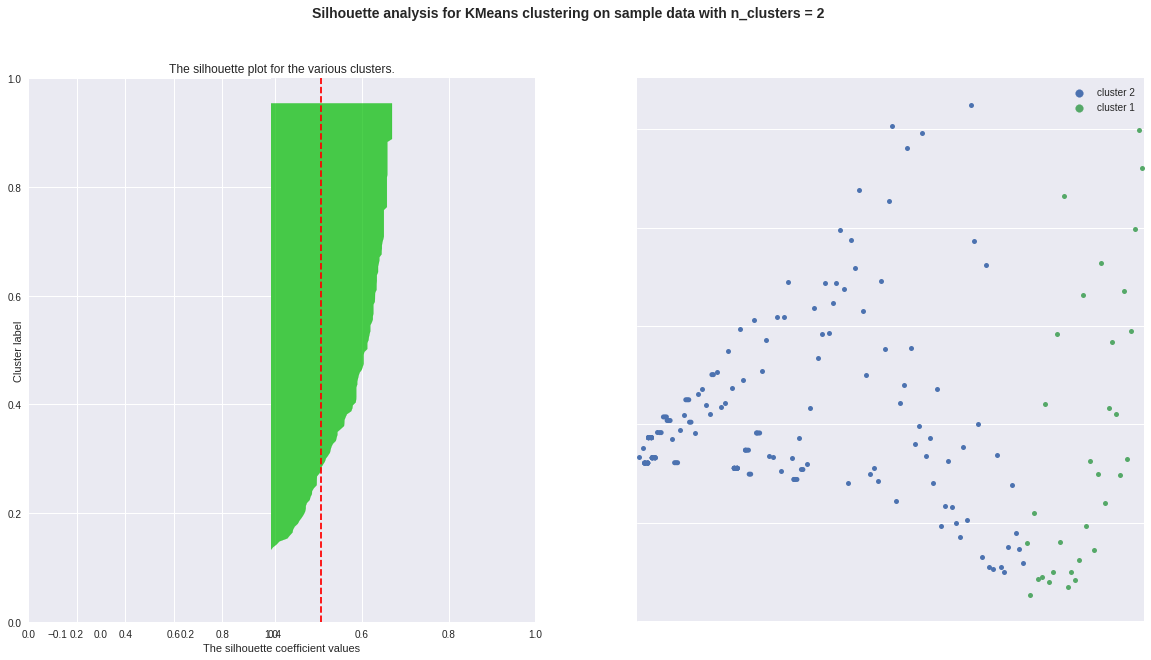

In [62]:
for i, clusters in enumerate([2]):
    kmeans_of_sample(plants_df, 200, i, clusters)

2018-01-27 00:29:14.060906 :: START :: i=0 c=2
2018-01-27 00:29:14.479129 :: DONE :: 0:00:00.417817
For n_clusters = 2 The average silhouette_score is : 0.546552634061
2018-01-27 00:29:14.481389 :: START :: i=1 c=3
2018-01-27 00:29:14.940897 :: DONE :: 0:00:00.459339
For n_clusters = 3 The average silhouette_score is : 0.457930919438
2018-01-27 00:29:14.943507 :: START :: i=2 c=6
2018-01-27 00:29:15.528555 :: DONE :: 0:00:00.584877
For n_clusters = 6 The average silhouette_score is : 0.282071681258
2018-01-27 00:29:15.532464 :: START :: i=3 c=14
2018-01-27 00:29:16.588159 :: DONE :: 0:00:01.055528
For n_clusters = 14 The average silhouette_score is : 0.127583767588


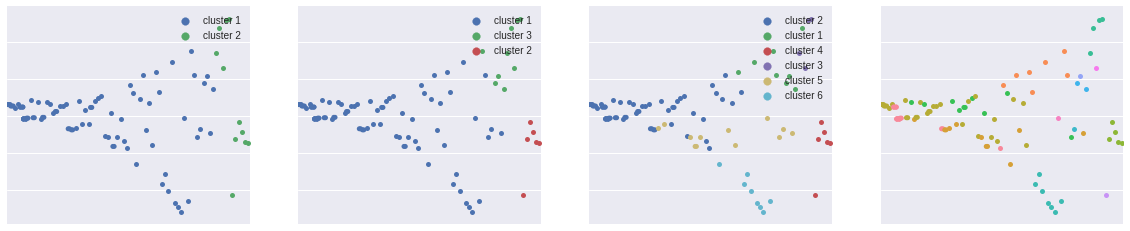

In [45]:
temp_df = plants_df.sample(100)
pca = PCA(n_components=number_of_dimensions)
pca.fit(temp_df)
plants_2d = pca.transform(temp_df)
fig = plt.figure(figsize=(20,4))

for i, clusters in enumerate(number_of_clusters):
    print("{} :: START :: i={} c={}".format(datetime.datetime.now(), i, clusters))
    tstart = datetime.datetime.now()
    fig.add_subplot(101+i+10*len(number_of_clusters))
    kmeans = KMeans(n_clusters=clusters)
    l = kmeans.fit(temp_df)
    labels = ['cluster ' + str(label+1) for label in kmeans.labels_]
    ax = sns.swarmplot(x=plants_2d[:,0], y=plants_2d[:,1], hue=labels)
    ax.set(xticklabels=[])
    ax.set(yticklabels=[])
    ax.legend(loc='upper right')
    if i == 3: 
        ax.legend_.remove()
    print("{} :: DONE :: {}".format(datetime.datetime.now(), datetime.datetime.now() - tstart ))
    silhouette_avg = silhouette_score(temp_df, kmeans.labels_)
    print("For n_clusters =", clusters, "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(temp_df, kmeans.labels_)

In [ ]:
# 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")
